# <span style="color:black"> Numerical Simulation Laboratory (NSL) </span>

## Francesco Gnan - <span style="color:grey">  Numerical Exercises 4</span>
------------------------------------------------------------------------------------------------------------------------------

# <span style="color:red"> Introduction </span>

In this exercise we want to perform a **Molecular Dynamics** (MD) simulation. In particular, we want to simulate the microscopic behavior of a Lennard-Jones fluid from the description of the inter-particle interaction potential. Our goal is to measure some macroscopic quantities of the system, such as temperature and pressure. Before making these measurements, we will equilibrate the system, to prevent these macroscopic properties from changing over time.

More precisely, we will solve Newton's equations of motion for a set of N particles, calculating the forces acting on each particle, known the atom-atom interaction potential ($F = - \nabla V$).

We will simulate (using reduced units) a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)


------------------------------------------------------------------------------------------------------------------------------

# <span style="color:red"> Theoretical recalls </span>

1. We will work using the code <font face = "Courier"> `MD_MC.cpp` </font> that generates states sampled from a **micro-canonical ensemle**: any member of the ensemble is equally likely to be in any one of the various possible microstates.
Therefore, during our simulation, we will not need to know the exact trajectory of the particles of the system, but we will take care to ensure the **conservation of energy**.
Since we assume that microstates with equal energy have equal probability, we want the particle trajectories to lie on a constant-energy hypersurface in phase space, to ensure correct ensemble averages.


-------------------------------------------------------------------------------------------------------------------------------
2. Due to the complexity of the potential energy function, there is no analytical solution to the equations of motion: the code <font face = "Courier"> `MD_MC.cpp` </font> solves these equations numerically in function <font face = "Courier"> `Move()` </font> thanks to the **Verlet algorithm**:


$$\vec{r}(t + \delta t) \approx 2\vec{r}(t) - \vec{r}(t - \delta t) + \delta t^2 \vec{a}(t)$$
$$\vec{v}(t) \approx \frac{\vec{r}(t + \delta t) - \vec{r}(t - \delta t)}{2\delta t}$$

This method has excellent energy-conserving properties even with long time steps.

-------------------------------------------------------------------------------------------------------------------------------
3. We will implement **periodic boundary conditions** (pbc) thanks to the function <font face = "Courier"> `Pbc(double r)` </font>: a cubic box is replicated throughout space to form an infinite lattice. We can adopt this approximation because we will study a fluid of Lennard-Jones atoms, characterized by a **short range** atom-atom interaction potenzial.

-------------------------------------------------------------------------------------------------------------------------------
4. To calculate the forces acting on each particle we will adopt the **minimum image convention**: molecule A interacts with all the molecules, whose centres lie within a region which is centered on molecule A and that has the same dimensions as the box.

In other words, it interacts with the closest periodic images of the other N-1 molecules.

-------------------------------------------------------------------------------------------------------------------------------
5. Moreover, since we will deal with short-range forces, we will apply a **spherical cutoff**, setting the interaction pair potential to zero for $r > r_c$. This approximation will cause errors in the estimation of the potential energy of the system.

-------------------------------------------------------------------------------------------------------------------------------
6. We also assume the **ergodic hypothesis**: the ensemble averages at equilibrium do not depend on time and the equilibrium properties of the system do not depend on the choice of initial conditions. 

In every simulation we will initialize our system in the **crystal structure** configuration, thanks to the positions saved in the file <font face = "Courier"> `config.in` </font>.

-------------------------------------------------------------------------------------------------------------------------------

7. Finally, we will express quantities in **reduced units** to take advantage of the **law of corresponding states** and to avoid overflow or underflow problems:
$$r^* = \frac{r}{\sigma} \qquad V^* = \frac{V}{\epsilon} \qquad P^* = \frac{P\sigma^3}{\epsilon} \qquad \rho^* = \rho\sigma^3 \qquad T^* = \frac{k_B T}{\epsilon}$$

Below there is a list of the packages that will be used during this notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# <span style="color:red"> Equilibration </span>

At this preliminary stage we start simulations from $N = 2000$ blocks with $nstep = 1$ each; i.e. we investigate the instantaneous temperature values to understand after how many steps the algorithm brings the system to an equilibrium state where temperature values oscillate around the desired $T^*$.

After finding the optimal starting temperature so that after $N$ steps the system is equilibrated, we insert a $N$ iterations <font face = "Courier"> `for` </font> loop, in which we call the <font face = "Courier"> `Move()` </font> function before block averaging.

The **temperature drop** in the solid and liquid is due to the fact that, in the crystalline configuration, the system is in a potential energy minimum, and therefore, when the simulation starts, the potential energy value will tend to increase.
Since in the microcanonical ensemble hypothesis the total energy must be constant, the kinetic energy, and thus the temperature, will experience a drop.

In the **case of the gas**, however, the density is much lower than in the two previous cases; therefore, in the initial configuration, the particles will be far away from each other.
They will have little interaction and so the system will be at a position of the interaction potential far from the minimum. The potential energy, as the system evolves and the particles move closer to each other, will tend to decrease and the temperature therefore will increase. In addition, in the case of gas, temperature takes more steps to reach equilibrium.

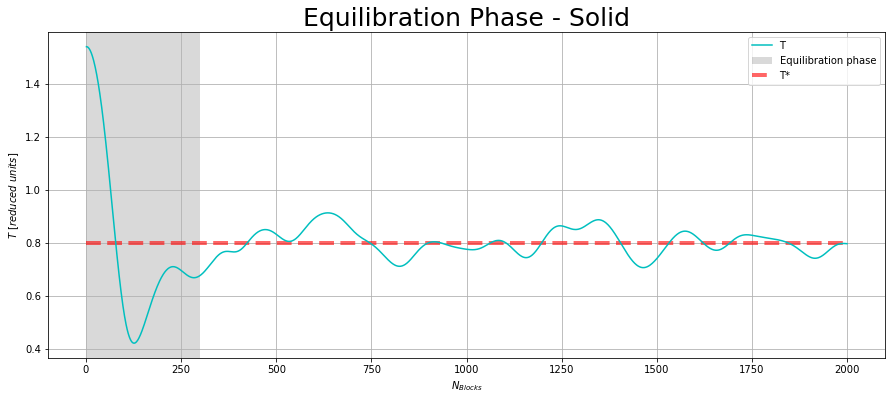

Final temperature: 0.797257


In [11]:
x1, temp1 = np.loadtxt("./Risultati/Solid/correct_temp.dat", usecols=(0,1), unpack='true')
x2, temp2 = np.loadtxt("./Risultati/Liquid/correct_temp.dat",usecols=(0,1), unpack='true')
x3, temp3 = np.loadtxt("./Risultati/Gas/Eq_temp.dat",usecols=(0,1), unpack='true')

plt.figure(figsize=(15,6))
plt.title("Equilibration Phase - Solid", fontsize=25)
plt.plot(x1,temp1, label = 'T',color='c')
plt.xlabel('$N_{Blocks}$')
plt.ylabel('$T \,\,[reduced \,\,units]$')
plt.hlines(0.8,0,2000, color='red', linestyle='--', label="T*", linewidth=4, alpha=0.6)
plt.axvspan(0, 300, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.legend()
plt.grid(True)
plt.show()
print('Final temperature: ' +str(temp1[-1]))

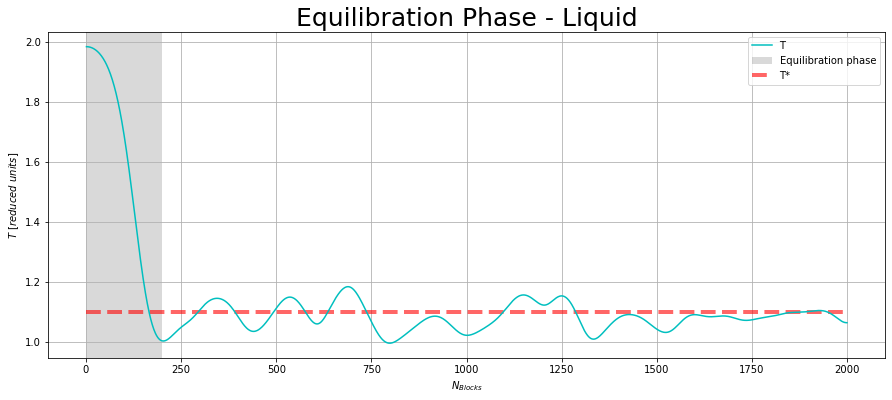

Final temperature: 1.064


In [12]:
plt.figure(figsize=(15,6))
plt.title("Equilibration Phase - Liquid", fontsize=25)

plt.plot(x2,temp2, label = 'T',color='c')
plt.xlabel('$N_{Blocks}$')
plt.ylabel('$T\,\, [reduced \,\,units]$')
plt.hlines(1.1,0,2000, color='red', linestyle='--', label="T*", linewidth=4, alpha=0.6)
plt.axvspan(0, 200, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.legend()
plt.grid(True)
plt.show()
print('Final temperature: ' +str(temp2[-1]))

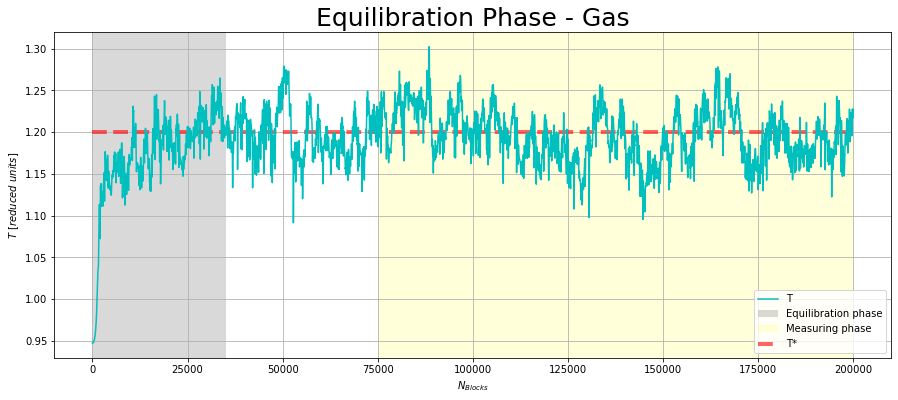

In [14]:
plt.figure(figsize=(15,6))
plt.title("Equilibration Phase - Gas", fontsize=25)

plt.plot(x3,temp3, label = 'T',color='c')
plt.xlabel('$N_{Blocks}$')
plt.ylabel('$T\,\, [reduced \,\,units]$')
plt.hlines(1.2,0,200000, color='red', linestyle='--', label="T*", linewidth=4, alpha=0.6)
plt.axvspan(0, 35000, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.axvspan(75000, 200000, facecolor='yellow', alpha=0.15, label='Measuring phase')
plt.legend()
plt.grid(True)
plt.show()

In the case of gas, even after the equilibration step, the fluctuations around the $T^*$ value are so large that it is necessary to integrate over a sufficiently large number of steps to mediate overestimates with underestimates.

# <span style="color:red"> Measures - solid </span>

In [22]:
file_solid = np.array(["./Risultati/Solid/S_ekin.dat",
                       "./Risultati/Solid/S_epot.dat",
                       "./Risultati/Solid/S_etot.dat",
                       "./Risultati/Solid/S_press.dat",
                       "./Risultati/Solid/S_temp.dat"])

file_liquid = np.array(["./Risultati/Liquid/L_ekin.dat",
                        "./Risultati/Liquid/L_epot.dat",
                        "./Risultati/Liquid/L_etot.dat",
                        "./Risultati/Liquid/L_press.dat",
                        "./Risultati/Liquid/L_temp.dat"])

file_gas = np.array(["./Risultati/Gas/G_ekin.dat",
                     "./Risultati/Gas/G_epot.dat",
                     "./Risultati/Gas/G_etot.dat",
                     "./Risultati/Gas/G_press.dat",
                     "./Risultati/Gas/G_temp.dat"])

title = np.array(["Kinetic energy","Potential energy","Total energy","Pressure", "Temperature"])


The following animations were created with <font face = "Courier"> `Ovito` </font> from saving instantaneous particle positions to <font face = "Courier"> `.xyz` </font> files.

In [3]:
Image(url= "./Risultati/Ovito/Solid/SOLIDO.gif", width=600, height=600)

The analysis is divided into 100 blocks of 2000 steps each.

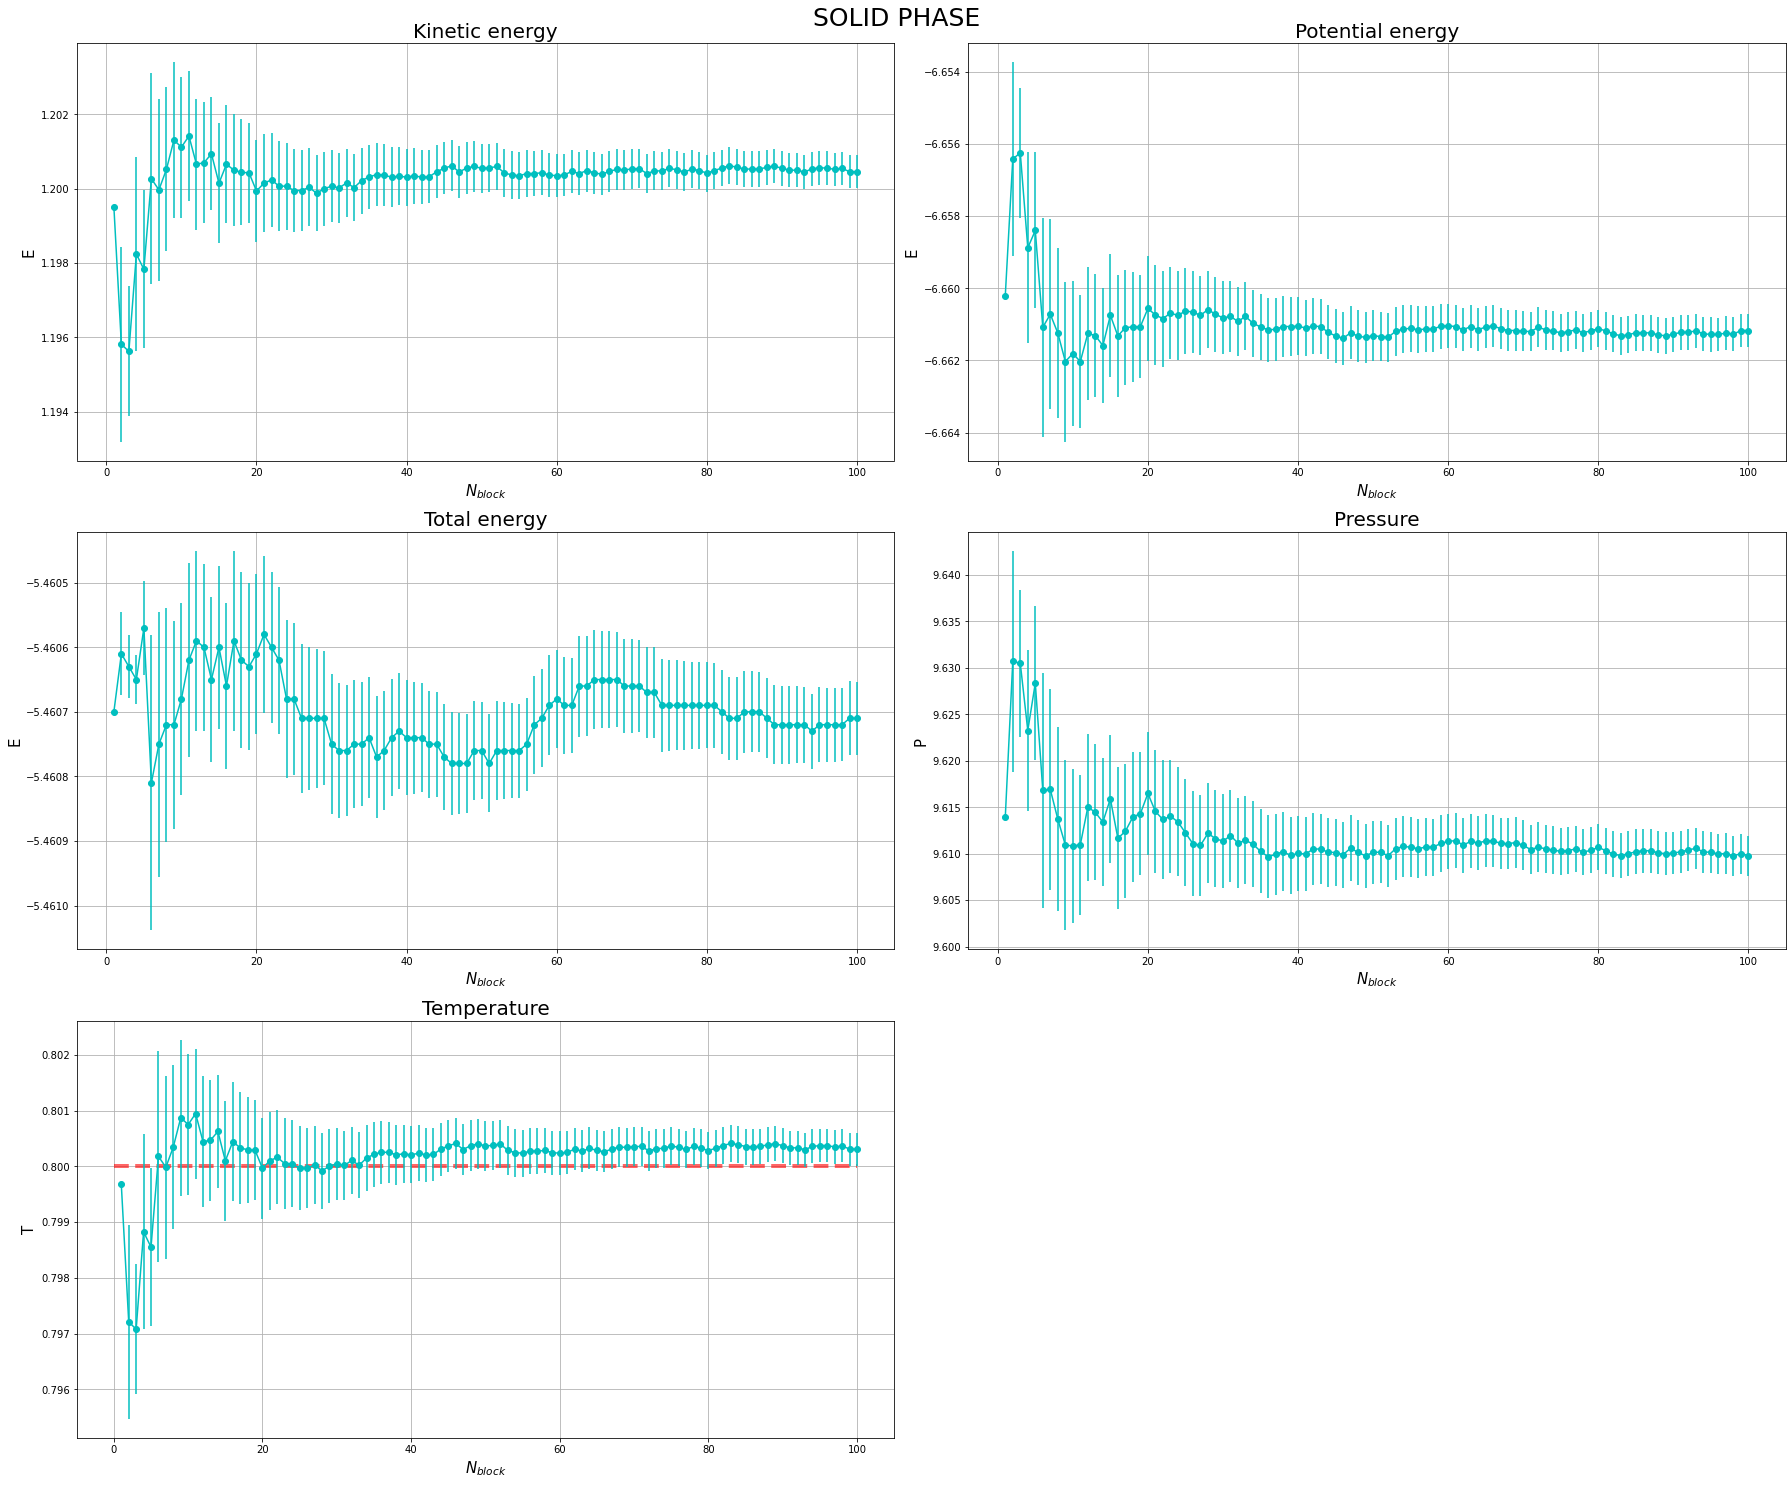

In [27]:
plt.figure(figsize=(25,21))
plt.suptitle('SOLID PHASE',fontsize=25)

for i in range(5):
    blk, ave, error = np.loadtxt(file_solid[i], usecols=(0,2,3), unpack='true')
    plt.subplot(3,2,i+1)
    if( i <= 2 ):
        plt.ylabel('E', fontsize = 15)
    elif( i == 3  ):
        plt.ylabel('P', fontsize = 15)    
    elif( i == 4 ):
        plt.hlines(0.8,0,100, color='red', linestyle='--', label="T*", linewidth=4, alpha=0.6)
        plt.ylabel('T', fontsize = 15)

   
    plt.title(title[i],fontsize=20)
    plt.errorbar(blk,ave,yerr=error,color='c',marker='o')
    plt.xlabel(r'$N_{block}$', fontsize=15)    
    plt.grid(True)

plt.tight_layout()
plt.show()

# <span style="color:red"> Measures - liquid </span>

In [4]:
Image(url= "./Risultati/Ovito/Liquid/LIQUIDO.gif", width=600, height=600)

The analysis is divided into 100 blocks of 2000 steps each.

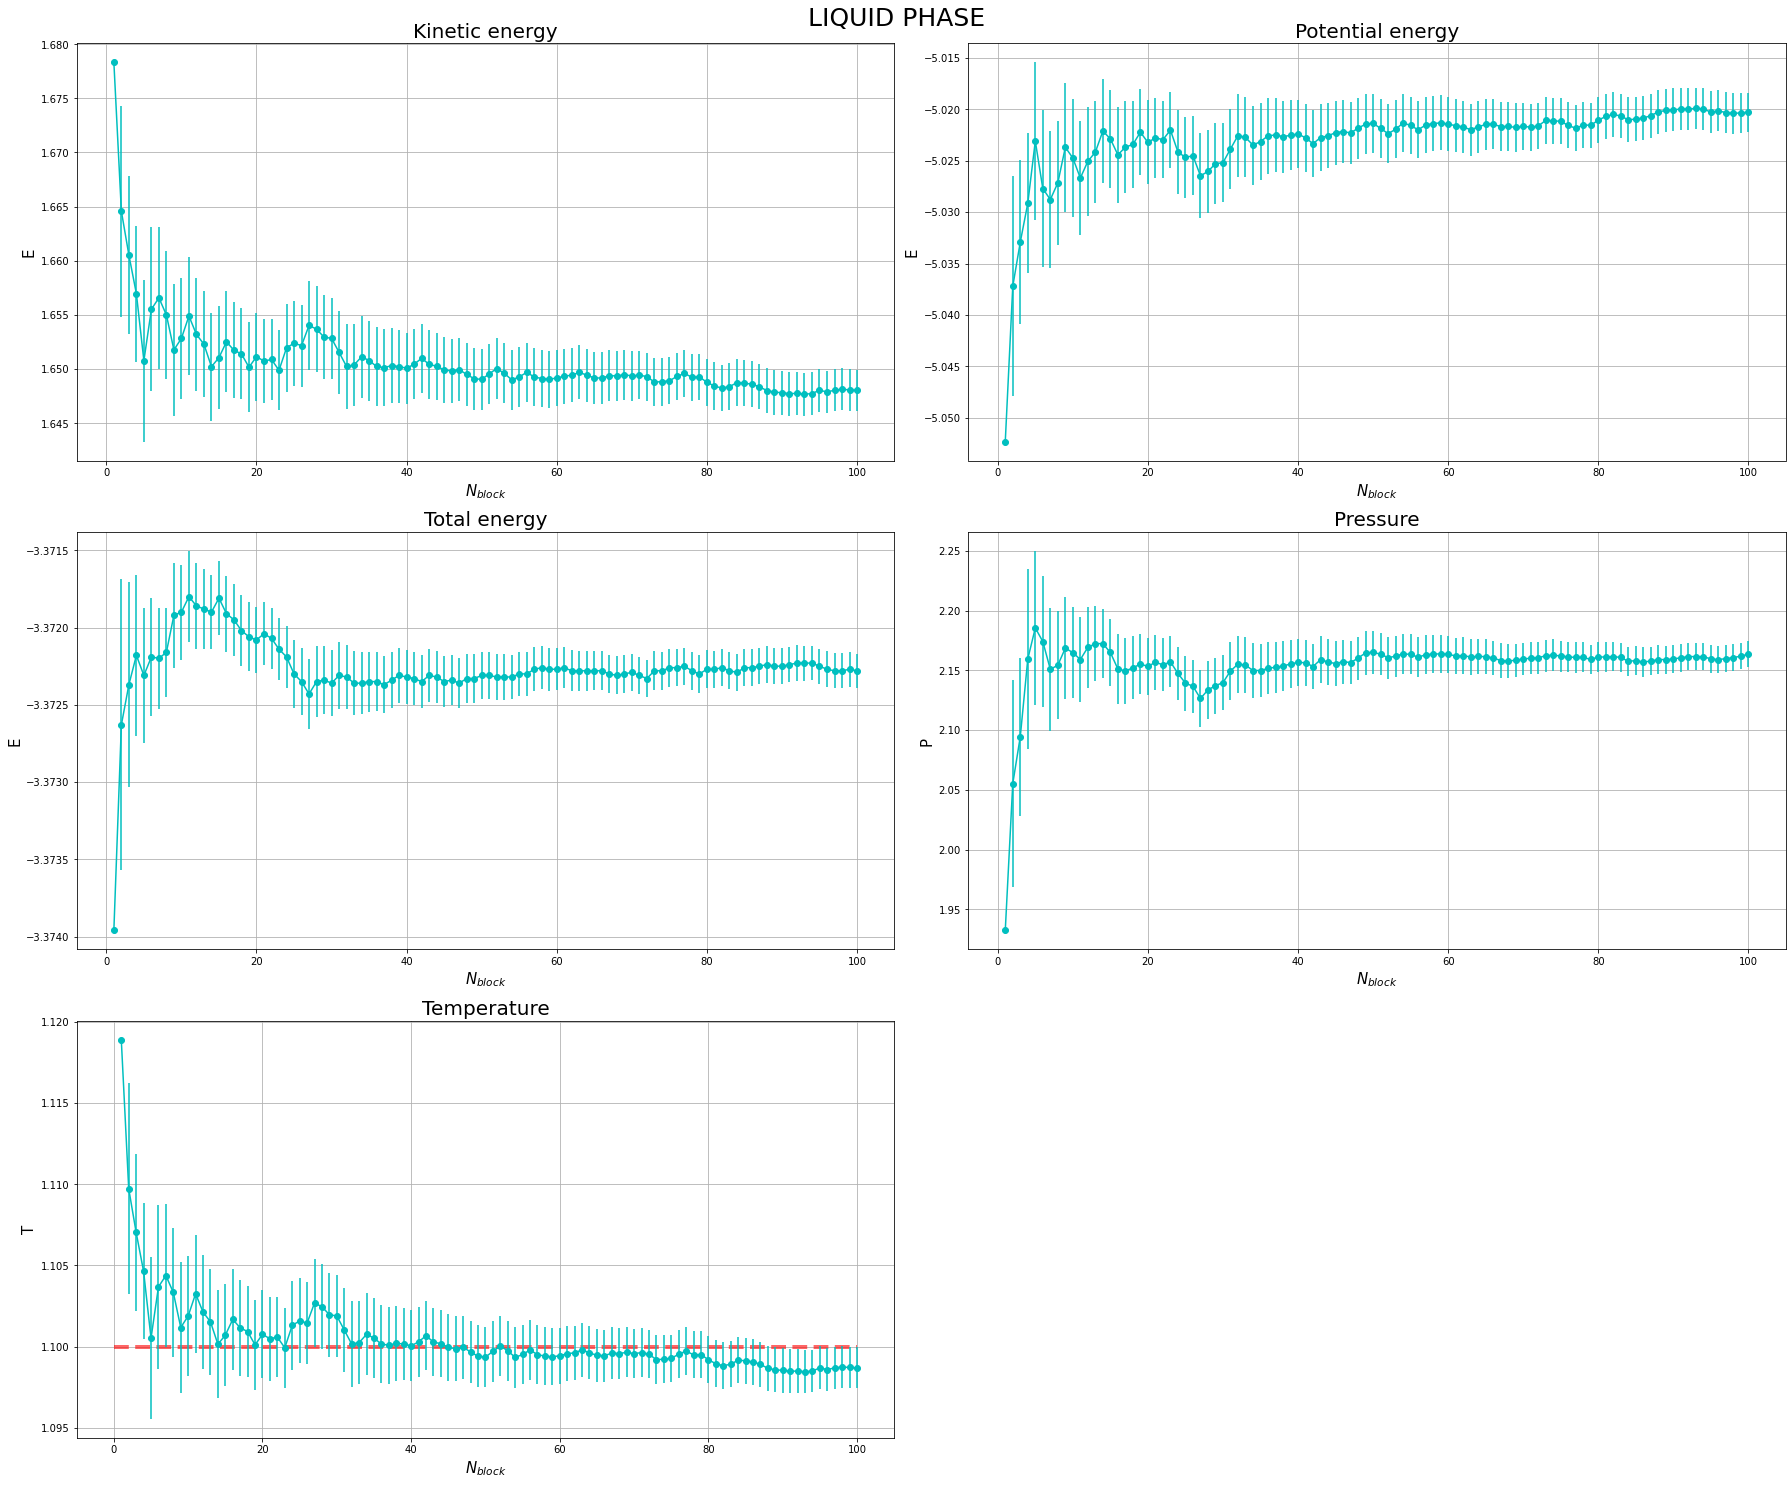

In [28]:
plt.figure(figsize=(25,21))
plt.suptitle('LIQUID PHASE',fontsize=25)

for i in range(5):
    blk, ave, error = np.loadtxt(file_liquid[i], usecols=(0,2,3), unpack='true')
    plt.subplot(3,2,i+1)
    if( i <= 2 ):
        plt.ylabel('E', fontsize = 15)
    elif( i == 3  ):
        plt.ylabel('P', fontsize = 15)    
    elif( i == 4 ):
        plt.hlines(1.1,0,100, color='red', linestyle='--', label="T*", linewidth=4, alpha=0.6)
        plt.ylabel('T', fontsize = 15)

   
    plt.title(title[i],fontsize=20)
    plt.errorbar(blk,ave,yerr=error,color='c',marker='o')
    plt.xlabel(r'$N_{block}$', fontsize=15)    
    plt.grid(True)

plt.tight_layout()
plt.show()

# <span style="color:red"> Measures - gas </span>

In [5]:
Image(url= "./Risultati/Ovito/Gas/Gas.gif", width=600, height=600)

In the equilibration graph, it is observed that, compared with the other two cases, the instantaneous temperature values fluctuate greatly around the value sought.
The instantaneous temperature has periodically repeating overestimates and underestimates of $T^*$.
Therefore, after 75000 steps of equilibration, 20 blocks of 6250 steps each are performed.
In this way it is possible to average the temperature overestimates with the underestimates along a certain number of periods.

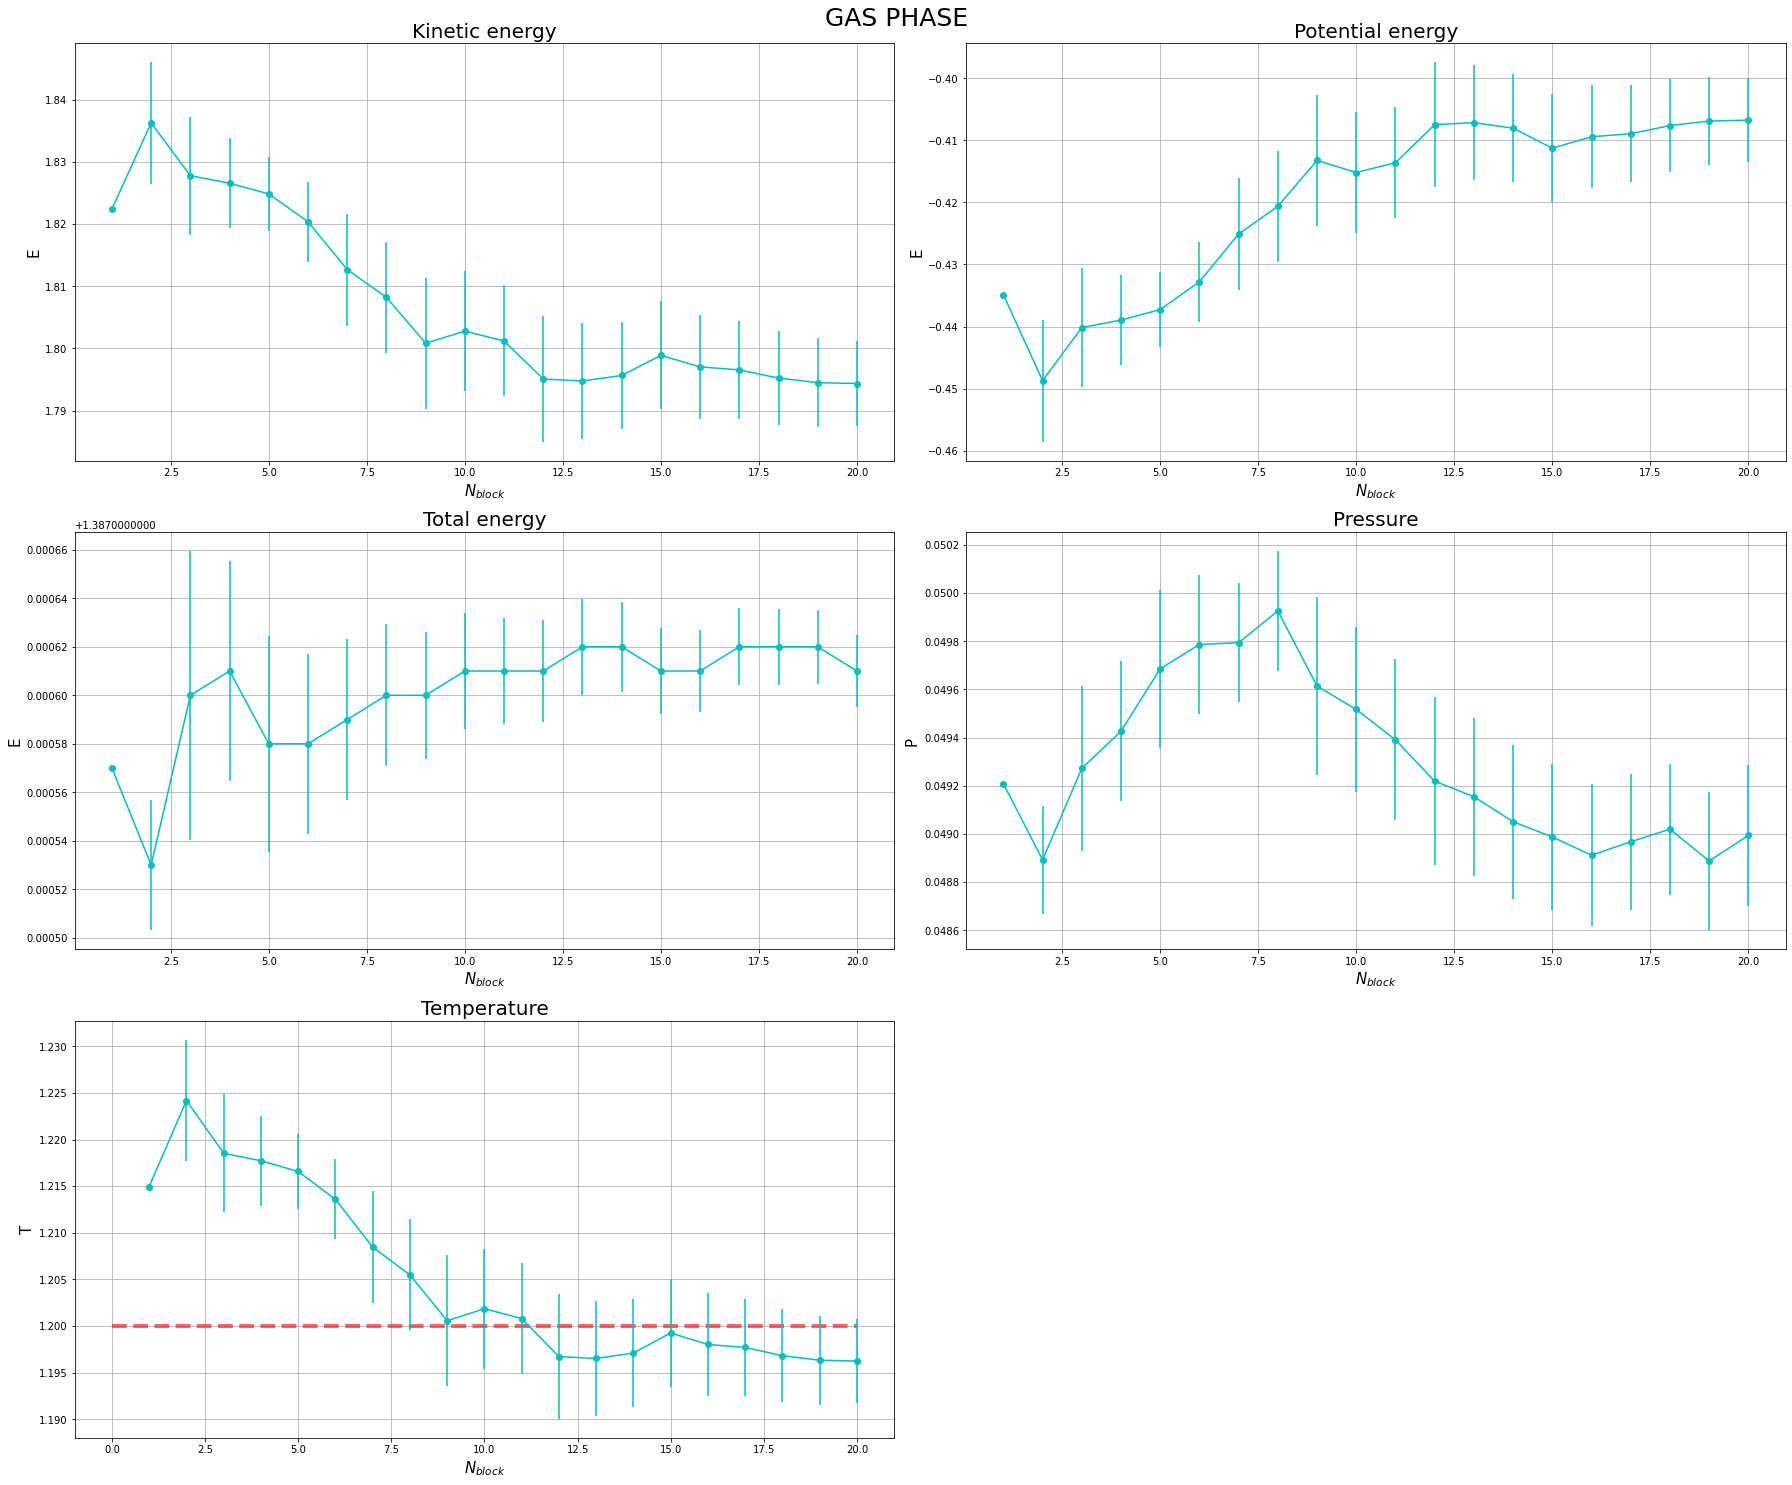

In [29]:
plt.figure(figsize=(25,21))
plt.suptitle('GAS PHASE',fontsize=25)

for i in range(5):
    blk, ave, error = np.loadtxt(file_gas[i], usecols=(0,2,3), unpack='true')
    plt.subplot(3,2,i+1)
    if( i <= 2 ):
        plt.ylabel('E', fontsize = 15)
    elif( i == 3  ):
        plt.ylabel('P', fontsize = 15)    
    elif( i == 4 ):
        plt.hlines(1.2,0,20, color='red', linestyle='--', label="T*", linewidth=4, alpha=0.6)
        plt.ylabel('T', fontsize = 15)

   
    plt.title(title[i],fontsize=20)
    plt.errorbar(blk,ave,yerr=error,color='c',marker='o')
    plt.xlabel(r'$N_{block}$', fontsize=15)    
    plt.grid(True)

plt.tight_layout()
plt.show()